<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка-данных" data-toc-modified-id="Подготовка-данных-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка данных</a></span></li><li><span><a href="#Исследование-задачи" data-toc-modified-id="Исследование-задачи-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Исследование задачи</a></span></li><li><span><a href="#Борьба-с-дисбалансом" data-toc-modified-id="Борьба-с-дисбалансом-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Борьба с дисбалансом</a></span></li><li><span><a href="#Тестирование-модели" data-toc-modified-id="Тестирование-модели-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Тестирование модели</a></span></li><li><span><a href="#Чек-лист-готовности-проекта" data-toc-modified-id="Чек-лист-готовности-проекта-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Чек-лист готовности проекта</a></span></li></ul></div>

# Отток клиентов

Из «Бета-Банка» стали уходить клиенты. Каждый месяц. Немного, но заметно. Банковские маркетологи посчитали: сохранять текущих клиентов дешевле, чем привлекать новых.

Нужно спрогнозировать, уйдёт клиент из банка в ближайшее время или нет. Вам предоставлены исторические данные о поведении клиентов и расторжении договоров с банком. 

Постройте модель с предельно большим значением *F1*-меры. Чтобы сдать проект успешно, нужно довести метрику до 0.59. Проверьте *F1*-меру на тестовой выборке самостоятельно.

Дополнительно измеряйте *AUC-ROC*, сравнивайте её значение с *F1*-мерой.

Источник данных: [https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling](https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling)

## Подготовка данных

In [16]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OrdinalEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix
from sklearn.utils import shuffle
from sklearn.dummy import DummyClassifier 
from sklearn.metrics import accuracy_score 
from sklearn.metrics import recall_score
!pip install fast_ml
from fast_ml.model_development import train_valid_test_split

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [17]:
data = pd.read_csv('https://code.s3.yandex.net/datasets/Churn.csv')
data.info()
data.head(5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           9091 non-null   float64
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(3), int64(8), object(3)
memory usage: 1.1+ MB


,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0


In [18]:
data['Geography'].value_counts()

France     5014
Germany    2509
Spain      2477
Name: Geography, dtype: int64

База данных представляет собой 10000 строк, пропуск данных есть только в столбце Tenure (сколько лет человек является клиентом банка). Можно предположить, что если данных об этом нет, то клиент является новым, можно проставить 0  

In [19]:
data['Tenure'] = data['Tenure'].fillna(0)


База данных содержит 14 колонок, из которых 3 категориальных.
В столбце Geography у нас есть 3 значения, Гендеров 2.  
Применим прямое кодирование к обоим признакам т.к использовать порядковое мы не можем в связи с использованием линейных моделей.  
Для избижания Dummy ловушек, избавимся от первых стоблцов. 

In [20]:
data['Gender'] = pd.get_dummies(data['Gender'], drop_first = 1)

In [21]:
Geography_ohe = pd.get_dummies(data['Geography'], drop_first = 1)
data = data.drop(['Geography'], axis = 1)
data = pd.merge(data,Geography_ohe, left_index=True, right_index = True)
data.head(5)

,RowNumber,CustomerId,Surname,CreditScore,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Germany,Spain
0,1,15634602,Hargrave,619,0,42,2.0,0.00,1,1,1,101348.88,1,0,0
1,2,15647311,Hill,608,0,41,1.0,83807.86,1,0,1,112542.58,0,0,1
2,3,15619304,Onio,502,0,42,8.0,159660.80,3,1,0,113931.57,1,0,0
3,4,15701354,Boni,699,0,39,1.0,0.00,2,0,0,93826.63,0,0,0
4,5,15737888,Mitchell,850,0,43,2.0,125510.82,1,1,1,79084.10,0,0,1


Столбец Surname не представляет для нас интерес, так же как RowNumber	и CustomerId т.к эти признаки отдельных лиц, а не класса (не)лояльных клиентов. 

In [22]:
data = data.drop(['Surname','RowNumber','CustomerId'],axis = 1)

*Хорошо бы в курсе на тренажёре об этом обратить внимание, а то сразу это непонятно. Возможно, об этом говорилось в модуле про категориальные данные, но тогда до ML было ещё далеко. *

## Исследование задачи

Сырые данные для обучения подготовили, теперь можно будет произвести разделение на обучающу, валидационную и тестовую выборки и обучить модели, не обращая внимание на дисбалансы классов. 

In [23]:
#features = data.drop(['Exited'], axis=1)
#target = data['Exited']
#print(features.shape)

#features_train, features_valid_n_test, tagret_train, target_valid_n_test = train_test_split(features, target, test_size=0.4, random_state=12345)
#features_valid, features_test, target_valid, target_test = train_test_split(features_valid_n_test,target_valid_n_test, test_size =0.5, random_state=12345)

features_train, target_train, features_valid, target_valid, features_test, target_test = train_valid_test_split(data, target='Exited', train_size = 0.6, valid_size = 0.2, test_size=.2 ) 

print(features_train.shape)
print(target_train.shape)
print(features_valid.shape)
print(features_test.shape)


(6000, 11)
(6000,)
(2000, 11)
(2000, 11)


Можно ли поделить на обучающую, тестовую и валидационну выгрузку в одну стороку?

*Функция, безусловно, хорошая, но после ознакомления с ней я сильно зауважал документацию pandas и sklearn*

Целевой признак у нас бинарный, так что мы решаем задачу класификации. Поэтому обучать будем модели класификации.

In [24]:
best_DT_row_nb_f1 = 0
best_DT_row_depth = 0
best_DT_row_leaf = 0
best_DT_row_model = None

for depth in range(1, 101, 5):
  for leaf in range(2,10):
    model = DecisionTreeClassifier(max_depth = depth, min_samples_leaf = leaf, random_state = 12345)
    model.fit(features_train, target_train)
    prediction = model.predict(features_valid)
    f1 = f1_score(target_valid, prediction)
    if f1 > best_DT_row_nb_f1:
      best_DT_row_nb_f1 = f1
      best_DT_row_depth = depth
      best_DT_row_leaf = leaf
      best_DT_row_model = model


best_DT_prediction = best_DT_row_model.predict_proba(features_valid)[:,1]
best_DT_row_nb_auc = roc_auc_score(target_valid, best_DT_prediction)

print(f'''Лучшая модель Дерева Решений {best_DT_row_model}
      Лучшая f1 {best_DT_row_nb_f1} , roc_auc {best_DT_row_nb_auc} ''')


Лучшая модель Дерева Решений DecisionTreeClassifier(max_depth=6, min_samples_leaf=9, random_state=12345)
      Лучшая f1 0.5598705501618123 , roc_auc 0.827359375 


In [25]:
best_RFC_row_nb_f1 = 0
best_RFC_row_depth = 0
best_RFC_row_est = 0
best_RFC_row_model = None

for est in range(1,101,10):
  for depth in range(1,21,5):
    model = RandomForestClassifier(n_estimators = est, max_depth = depth, random_state=12345)
    model.fit(features_train, target_train)
    prediction = model.predict(features_valid)
    f1 = f1_score(target_valid, prediction)
    if f1 > best_RFC_row_nb_f1:
      best_RFC_row_nb_f1 = f1
      best_RFC_row_depth = depth
      best_RFC_row_est = est
      best_RFC_row_model = model


best_RFC_prediction = best_RFC_row_model.predict_proba(features_valid)[:,1]
best_RFC_row_nb_auc = roc_auc_score(target_valid, best_RFC_prediction)

print(f'''Лучшая модель Случайного Леса {best_RFC_row_model}
      Лучшая f1 {best_RFC_row_nb_f1} , roc_auc {best_RFC_row_nb_auc} ''')

Лучшая модель Случайного Леса RandomForestClassifier(max_depth=16, n_estimators=51, random_state=12345)
      Лучшая f1 0.588235294117647 , roc_auc 0.8463804687500001 


In [26]:
best_LR_row_nb_f1 = 0
best_LR_solver = None
best_LR_max_iter = 0
best_LR_row_model = None

solvers = ['liblinear', 'lbfgs', 'sag', 'saga'] #'newton-cg'

for solver_i in solvers:
  for iter in range(100, 500 , 20):
    model = LogisticRegression(solver = solver_i, max_iter= iter)
    model.fit(features_train, target_train)
    prediction = model.predict(features_valid)
    f1 = f1_score(target_valid, prediction)
    if f1 > best_LR_row_nb_f1: 
      best_LR_row_nb_f1 = f1
      best_LR_solver = solver_i
      best_LR_max_iter = 0
      best_LR_row_model = model


best_LR_pred = best_LR_row_model.predict_proba(features_valid)[:,1]
best_LR_row_nb_auc = roc_auc_score(target_valid, best_LR_pred)

print(f'''Лучшая модель Логистической регрессии {best_LR_row_model}, best_LR_solver={best_LR_solver}, iter = {best_LR_max_iter} 
      Лучшая f1 {best_LR_row_nb_f1} , roc_auc {best_LR_row_nb_auc} ''')

Лучшая модель Логистической регрессии LogisticRegression(solver='liblinear'), best_LR_solver=liblinear, iter = 0 
      Лучшая f1 0.0944206008583691 , roc_auc 0.6489296874999999 


Проверим лучшие модели.

 *Лучший показатель F1  на сырых данных на валидационной выборке без учёта дисбаланса классов  составил 0.49 для модели Дерева Решений.  
Очевидно, что без дополнительной работы над данными, получить показатель в 0.57 не выйдет.*

Лучший показатель F1 на сырых данных без учёта дисбаланса, но с убранными неинформативными признаками составил 0.54 для модели Случайного Леса. Roc_auc при этом составило 0.47.   
Можем наблюдать, что удаление неинфорамцинных признаков улучшило работу модели.

## Борьба с дисбалансом

Проведём обучение на той  же выбрке, но с параметном class_weight='balanced'

In [27]:
best_DT_row_b_f1 = 0
best_DT_row_depth = 0
best_DT_row_leaf = 0
best_DT_row_model = None

for depth in range(1, 101, 5):
  for leaf in range(2,10):
    model = DecisionTreeClassifier(max_depth = depth, min_samples_leaf = leaf, random_state = 12345,class_weight='balanced' )
    model.fit(features_train, target_train)
    prediction = model.predict(features_valid)
    f1 = f1_score(target_valid, prediction)
    if f1 > best_DT_row_b_f1:
      best_DT_row_b_f1 = f1
      best_DT_row_depth = depth
      best_DT_row_leaf = leaf
      best_DT_row_model = model


best_DT_prediction = best_DT_row_model.predict_proba(features_valid)[:,1]
best_DT_row_b_auc = roc_auc_score(target_valid, best_DT_prediction)

print(f'''Лучшая модель Дерева Решений {best_DT_row_model}
      Лучшая f1 {best_DT_row_b_f1} , roc_auc {best_DT_row_b_auc} ''')


Лучшая модель Дерева Решений DecisionTreeClassifier(class_weight='balanced', max_depth=6, min_samples_leaf=8,
                       random_state=12345)
      Лучшая f1 0.5574977000919964 , roc_auc 0.8368484374999999 


In [28]:
best_RFC_row_b_f1 = 0
best_RFC_row_depth = 0
best_RFC_row_est = 0
best_RFC_row_model = None

for est in range(1,101,10):
  for depth in range(1,21,5):
    model = RandomForestClassifier(n_estimators = est, max_depth = depth, random_state=12345, class_weight='balanced')
    model.fit(features_train, target_train)
    prediction = model.predict(features_valid)
    f1 = f1_score(target_valid, prediction)
    if f1 > best_RFC_row_b_f1:
      best_RFC_row_b_f1 = f1
      best_RFC_row_depth = depth
      best_RFC_row_est = est
      best_RFC_row_model = model


best_RFC_prediction = best_RFC_row_model.predict_proba(features_valid)[:,1]
best_RFC_row_b_auc = roc_auc_score(target_valid, best_RFC_prediction)

print(f'''Лучшая модель Случайного Леса {best_RFC_row_model}
      Лучшая f1 {best_RFC_row_b_f1} , roc_auc {best_RFC_row_b_auc} ''')

Лучшая модель Случайного Леса RandomForestClassifier(class_weight='balanced', max_depth=11, n_estimators=71,
                       random_state=12345)
      Лучшая f1 0.6157894736842106 , roc_auc 0.84773125 


In [29]:
best_LR_row_b_f1 = 0
best_LR_solver = None
best_LR_max_iter = 0
best_LR_row_model = None

solvers = ['liblinear', 'lbfgs', 'sag', 'saga'] #'newton-cg'

for solver_i in solvers:
  for iter in range(100, 500 , 20):
    model = LogisticRegression(solver = solver_i, max_iter= iter, class_weight='balanced')
    model.fit(features_train, target_train)
    prediction = model.predict(features_valid)
    f1 = f1_score(target_valid, prediction)
    if f1 > best_LR_row_b_f1: 
      best_LR_row_b_f1 = f1
      best_LR_solver = solver_i
      best_LR_max_iter = iter
      best_LR_row_model = model


best_LR_pred = best_LR_row_model.predict_proba(features_valid)[:,1]
best_LR_row_b_auc = roc_auc_score(target_valid, best_LR_pred)

print(f'''Лучшая модель Логистической регрессии {best_LR_row_model}, best_LR_solver={best_LR_solver}, iter = {best_LR_max_iter} 
      Лучшая f1 {best_LR_row_b_f1} , roc_auc {best_LR_row_b_auc} ''')

Лучшая модель Логистической регрессии LogisticRegression(class_weight='balanced', solver='liblinear'), best_LR_solver=liblinear, iter = 100 
      Лучшая f1 0.43781942078364566 , roc_auc 0.709271875 


In [30]:
models =[best_DT_row_model,best_RFC_row_model, best_LR_row_model]

for model in models:
  pred = model.predict(features_valid)
  prob = model.predict_proba(features_valid)[:,1]
  f1 = f1_score(target_valid, pred)
  roc_auc = roc_auc_score(target_test, prob)
  print(f'''Показатели {model} на тестовой выборке С взвешиванием:
  F1 ={f1}
  roc_auc ={roc_auc}
  
  ''')

Показатели DecisionTreeClassifier(class_weight='balanced', max_depth=6, min_samples_leaf=8,
                       random_state=12345) на тестовой выборке С взвешиванием:
  F1 =0.5574977000919964
  roc_auc =0.4893691975816667
  
  
Показатели RandomForestClassifier(class_weight='balanced', max_depth=11, n_estimators=71,
                       random_state=12345) на тестовой выборке С взвешиванием:
  F1 =0.6157894736842106
  roc_auc =0.48830184493104933
  
  
Показатели LogisticRegression(class_weight='balanced', solver='liblinear') на тестовой выборке С взвешиванием:
  F1 =0.43781942078364566
  roc_auc =0.5029659511506271
  
  


С параметром class_weight='balanced' качество моделей заметнор выросло.  
Для моджели Случайного Леса F1 составила приемлимые 0.61.  
Однако, не будем на этом останавливаться и попробуем устранить дисбаланс классов в данных. 

# Пере - подготовка данных к обучению.

В рамках борьбы с дисбалансами классов, сравним работу атрибута class_weight='balanced'  с обучением на подготовленных данных.  
Для этого отмасштабируем признаки и вручную удалим дисбаланс классов.

In [31]:
#numeric = ['CreditScore','Age', 'Tenure','Balance', 'NumOfProducts', 'EstimatedSalary'  ]
#scaler = StandardScaler()
#scaler.fit(features_train[numeric])

#features_train.loc[:,numeric] = scaler.transform(features_train[numeric])
#features_valid.loc[:,numeric] = scaler.transform(features_valid[numeric])

Масштабирование данных в данном работе приводит к сильному проседанию метрик. Поэтому её не используем.

In [32]:
target_valid.value_counts(normalize=1)

0    0.8
1    0.2
Name: Exited, dtype: float64

Мы видим, что у нас наблюдается дисбаланс классов - 0 в 4 раза больше, чем класса 1. Увеличим долю положительных результатов.

In [33]:
def upsampling(features, target, repeat):
  features_zero = features[target==0]
  features_ones = features[target==1]
  target_zero = target[target==0]
  target_ones = target[target==1]

  features_up = pd.concat([features_zero] + [features_ones] * repeat)
  target_up =pd.concat([target_zero] + [target_ones] * repeat )
  features_upsampled, target_upsampled = shuffle(features_up, target_up, random_state=12345)
  return features_upsampled, target_upsampled

In [34]:
features_train, target_train = upsampling(features_train, target_train, 4)

In [35]:
target_train.value_counts(normalize=1)

1    0.50363
0    0.49637
Name: Exited, dtype: float64

С подготовленными данными нужно будет повторить процес подбора лучших гиперпараметров.

In [36]:
best_DT_fix_f1 = 0
best_DT_fix_depth = 0
best_DT_fix_leaf = 0
best_DT_fix_model = None

for depth in range(1, 101, 5):
  for leaf in range(2,10):
    model = DecisionTreeClassifier(max_depth = depth, min_samples_leaf = leaf, random_state = 12345)
    model.fit(features_train, target_train)
    prediction = model.predict(features_valid)
    f1 = f1_score(target_valid, prediction)
    if f1 > best_DT_fix_f1:
      best_DT_fix_f1 = f1
      best_DT_fix_depth = depth
      best_DT_fix_leaf = leaf
      best_DT_fix_model = model

best_DT_prediction = best_DT_fix_model.predict_proba(features_valid)[:,1]
best_DT_fix_auc = roc_auc_score(target_valid, best_DT_prediction)

print(f'''Лучшая модель Дерева Решений {best_DT_fix_model}
      Лучшая f1 {best_DT_fix_f1} , roc_auc {best_DT_fix_auc} ''')


Лучшая модель Дерева Решений DecisionTreeClassifier(max_depth=6, min_samples_leaf=9, random_state=12345)
      Лучшая f1 0.5566820276497695 , roc_auc 0.8336718750000001 


In [37]:
best_RFC_fix_f1 = 0
best_RFC_fix_depth = 0
best_RFC_fix_est = 0
best_RFC_fix_model = None

for est in range(1,101,10):
  for depth in range(1,21,5):
    model = RandomForestClassifier(n_estimators = est, max_depth = depth, random_state=12345)
    model.fit(features_train, target_train)
    prediction = model.predict(features_valid)
    f1 = f1_score(target_valid, prediction)
    if f1 > best_RFC_fix_f1:
      best_RFC_fix_f1 = f1
      best_RFC_fix_depth = depth
      best_RFC_fix_est = est
      best_RFC_fix_model = model

best_RFC_prediction = best_RFC_fix_model.predict_proba(features_valid)[:,1]
best_RFC_fix_auc = roc_auc_score(target_valid, best_RFC_prediction)

print(f'''Лучшая модель Случайного Леса {best_RFC_fix_model}
      Лучшая f1 {best_RFC_fix_f1} , roc_auc {best_RFC_fix_auc} ''')


Лучшая модель Случайного Леса RandomForestClassifier(max_depth=11, n_estimators=91, random_state=12345)
      Лучшая f1 0.6225319396051103 , roc_auc 0.8485093749999999 


In [38]:
best_LR_fix_f1 = 0
best_LR_solver = None
best_LR_max_iter = 0
best_LR_fix_model = None

solvers = ['liblinear', 'lbfgs', 'sag', 'saga'] #'newton-cg',

for solver_i in solvers:
  for iter in range(100, 501 , 20):
    model = LogisticRegression(solver = solver_i, max_iter= iter)
    model.fit(features_train, target_train)
    prediction = model.predict(features_valid)
    f1 = f1_score(target_valid, prediction)
    if f1 > best_LR_fix_f1: 
      best_LR_fix_f1 = f1
      best_LR_solver = solver_i
      best_LR_max_iter = iter
      best_LR_fix_model = model

best_LR_pred = best_LR_fix_model.predict_proba(features_valid)[:,1]
best_LR_fix_auc = roc_auc_score(target_valid, best_LR_pred)

print(f'''Лучшая модель Логистической регрессии {best_LR_fix_model}, best_LR_solver={best_LR_solver}, iter = {best_LR_max_iter} 
      Лучшая f1 {best_LR_fix_f1} , roc_auc {best_LR_fix_auc} ''')


Лучшая модель Логистической регрессии LogisticRegression(solver='liblinear'), best_LR_solver=liblinear, iter = 100 
      Лучшая f1 0.42798353909465014 , roc_auc 0.6942234375 


In [39]:
models =[best_DT_fix_model,best_RFC_fix_model, best_LR_fix_model]

for model in models:
  pred = model.predict(features_valid)
  prob = model.predict_proba(features_valid)[:,1]
  f1 = f1_score(target_valid, pred)
  roc_auc = roc_auc_score(target_test, prob)
  print(f'''Показатели {model} на вплидационной выборке с обработкой данных:
  F1 = {f1}
  roc_auc = {roc_auc}
  
  ''')

Показатели DecisionTreeClassifier(max_depth=6, min_samples_leaf=9, random_state=12345) на вплидационной выборке с обработкой данных:
  F1 = 0.5566820276497695
  roc_auc = 0.4839035125196569
  
  
Показатели RandomForestClassifier(max_depth=11, n_estimators=91, random_state=12345) на вплидационной выборке с обработкой данных:
  F1 = 0.6225319396051103
  roc_auc = 0.4853111587821986
  
  
Показатели LogisticRegression(solver='liblinear') на вплидационной выборке с обработкой данных:
  F1 = 0.42798353909465014
  roc_auc = 0.5021564421178555
  
  


Лучшая модель на выборке с обработкой данных по прежнему модель Случайного Дерева. F1 

На валидационной выборке f1 у модели Случайного Леса смогла составить аж 0.64, что довольно сильно больше, чем 

## Тестирование модели

In [40]:
dummy_model = DummyClassifier(strategy = 'stratified' )
dummy_model.fit(features_train, target_train)


constant_model = pd.Series([1] * len(target_test))

models =[best_DT_fix_model,best_RFC_fix_model, best_RFC_row_model, best_LR_fix_model, dummy_model]

for model in models:
  pred = model.predict(features_test)
  prob = model.predict_proba(features_test)[:,1]
  f1 = f1_score(target_test, pred)
  roc_auc = roc_auc_score(target_test, prob)
  print(f'''Показатели {model} на тестовой выборке:
  F1 ={f1}
  roc_auc ={roc_auc}
  
  ''')

print(f'''Показатели constant_model на тестовой выборке:
F1 ={f1_score(target_test, constant_model)}
roc_auc ={roc_auc_score(target_test, constant_model)}''')


Показатели DecisionTreeClassifier(max_depth=6, min_samples_leaf=9, random_state=12345) на тестовой выборке:
  F1 =0.5566286215978928
  roc_auc =0.8214762746394312
  
  
Показатели RandomForestClassifier(max_depth=11, n_estimators=91, random_state=12345) на тестовой выборке:
  F1 =0.6002317497103128
  roc_auc =0.8473146036928604
  
  
Показатели RandomForestClassifier(class_weight='balanced', max_depth=11, n_estimators=71,
                       random_state=12345) на тестовой выборке:
  F1 =0.5921219822109276
  roc_auc =0.8461123328701143
  
  
Показатели LogisticRegression(solver='liblinear') на тестовой выборке:
  F1 =0.4275303643724696
  roc_auc =0.6846197781045796
  
  
Показатели DummyClassifier(strategy='stratified') на тестовой выборке:
  F1 =0.2965565706254392
  roc_auc =0.5140689671714105
  
  
Показатели constant_model на тестовой выборке:
F1 =0.3491539413949649
roc_auc =0.5


Хотя на валидационной выборке модель, обученная на "сырых" данных с атрибутом class_weight='balanced'была чуть лучше модели, обученной на данных с "ручным" исправлением дисбалансов классов, на тестовой выборке модель, обученная на обработанной выборке оказалась лучше.  
Можем наблюдать, что для модели Случайного Леса f1- метрика и roc_auc растут почти одинакого.  

In [41]:
importances = best_RFC_fix_model.feature_importances_
vazhno = pd.Series(importances, index =features_test.columns)

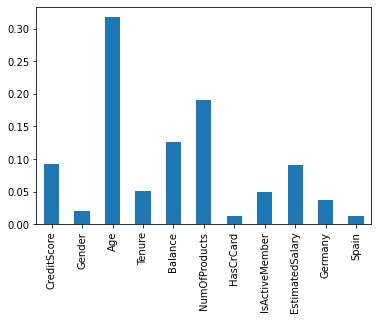

In [42]:
vazhno.plot(kind='bar') 

Как видим, самым важным показателем в модели выступает возраст, вторым - количество уже действующих кредитных продуктов.

Посмотрим на динамику F1 и roc_auc метрик в зависимости от балансирования классов на валидационной выгрузке.

In [57]:
f1 =[best_DT_row_nb_f1, best_RFC_row_nb_f1, best_LR_row_nb_f1, best_DT_row_b_f1, best_RFC_row_b_f1,best_LR_row_b_f1,best_DT_fix_f1, best_RFC_fix_f1, best_LR_fix_f1 ]
roc = [best_DT_row_nb_auc, best_RFC_row_nb_auc, best_LR_row_nb_auc, best_DT_row_b_auc, best_RFC_row_b_auc,best_LR_row_b_auc,best_DT_fix_auc, best_RFC_fix_auc, best_LR_fix_auc ]
name = ["best_DT_row_nb", "best_RFC_row_nb", "best_LR_row_nb", "best_DT_row_b", "best_RFC_row_b","best_LR_row_b", "best_DT_fix", "best_RFC_fix", "best_LR_fix"]

In [76]:
f1_vs_roc = pd.DataFrame(  index = [name],  columns = ['F1'])
f1_vs_roc['F1'] = f1
f1_vs_roc['ROC_AUC'] =roc
f1_vs_roc['Delta'] = f1_vs_roc['ROC_AUC'] - f1_vs_roc['F1']

In [77]:
f1_vs_roc

,F1,ROC_AUC,Delta
best_DT_row_nb,0.559871,0.827359,0.267489
best_RFC_row_nb,0.588235,0.846380,0.258145
best_LR_row_nb,0.094421,0.648930,0.554509
best_DT_row_b,0.557498,0.836848,0.279351
best_RFC_row_b,0.615789,0.847731,0.231942
best_LR_row_b,0.437819,0.709272,0.271452
best_DT_fix,0.556682,0.833672,0.276990
best_RFC_fix,0.622532,0.848509,0.225977
best_LR_fix,0.427984,0.694223,0.266240


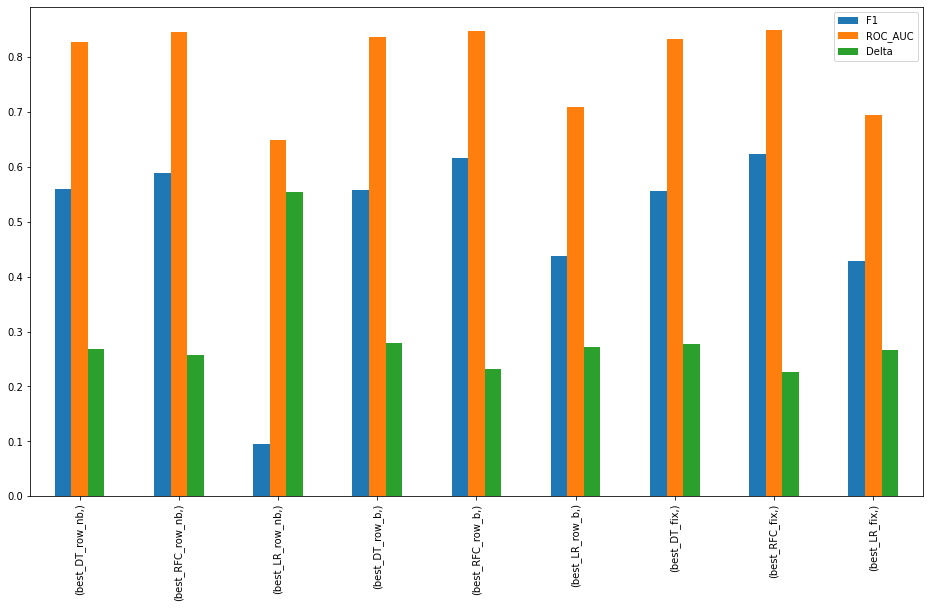

In [79]:
ax=f1_vs_roc.plot(kind='bar', figsize=(16,9))

Как видим, динамика F1 и ROC_AUC соноправлена, разница между метриками при балансировке классов и без неё остаётся практически одинаковая.   
Едиственное исключение - Логистическая Регрессия при обработке сырых данных. При балансировке классов, разница между F1 и ROC_AUC радикально сократилась. 

## Чек-лист готовности проекта

Поставьте 'x' в выполненных пунктах. Далее нажмите Shift+Enter.

- [x]  Jupyter Notebook открыт
- [ ]  Весь код выполняется без ошибок
- [ ]  Ячейки с кодом расположены в порядке исполнения
- [ ]  Выполнен шаг 1: данные подготовлены
- [ ]  Выполнен шаг 2: задача исследована
    - [ ]  Исследован баланс классов
    - [ ]  Изучены модели без учёта дисбаланса
    - [ ]  Написаны выводы по результатам исследования
- [ ]  Выполнен шаг 3: учтён дисбаланс
    - [ ]  Применено несколько способов борьбы с дисбалансом
    - [ ]  Написаны выводы по результатам исследования
- [ ]  Выполнен шаг 4: проведено тестирование
- [ ]  Удалось достичь *F1*-меры не менее 0.59
- [ ]  Исследована метрика *AUC-ROC*